# Time Series with Gaussian Processes
Adapted from: https://juanitorduz.github.io/gaussian_process_time_series/

In [309]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [310]:
# Number of samples. 
n = 1000
# Generate "time" variable. 
t = np.arange(n)

data_df = pd.DataFrame({'t' : t})

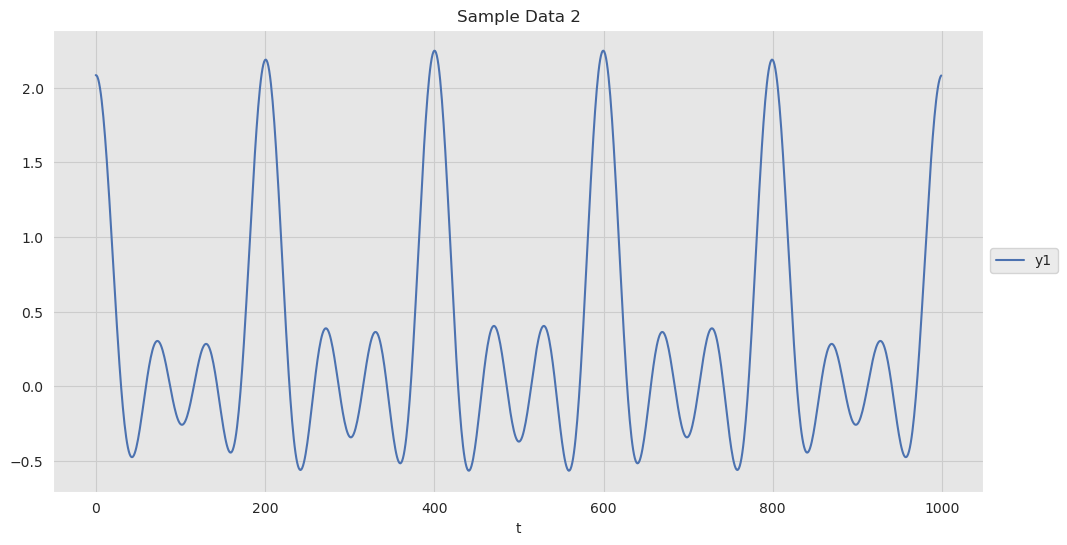

In [311]:
# Generate trend component. 
def sinc(x):
    if x == 0:
        return 1
    y = np.sin(x)/(x)
    return y 

def sinc_every(x, scale, pscale):
    y = 0
    for i in range(0, 6):
        y += scale*sinc(pscale*(x - i*200))
    return y

scale = 2
pscale = 0.1
data_df['sinc1'] = data_df['t'].apply(lambda x : sinc_every(x, scale, pscale))

# Add trend to target variable y_1. 
data_df['y1'] = data_df['sinc1']

# Let us see the trend plot:

fig, ax = plt.subplots()
sns.lineplot(x='t', y='y1', data=data_df, color=sns_c[0], label='y1', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Sample Data 2', xlabel='t', ylabel='');

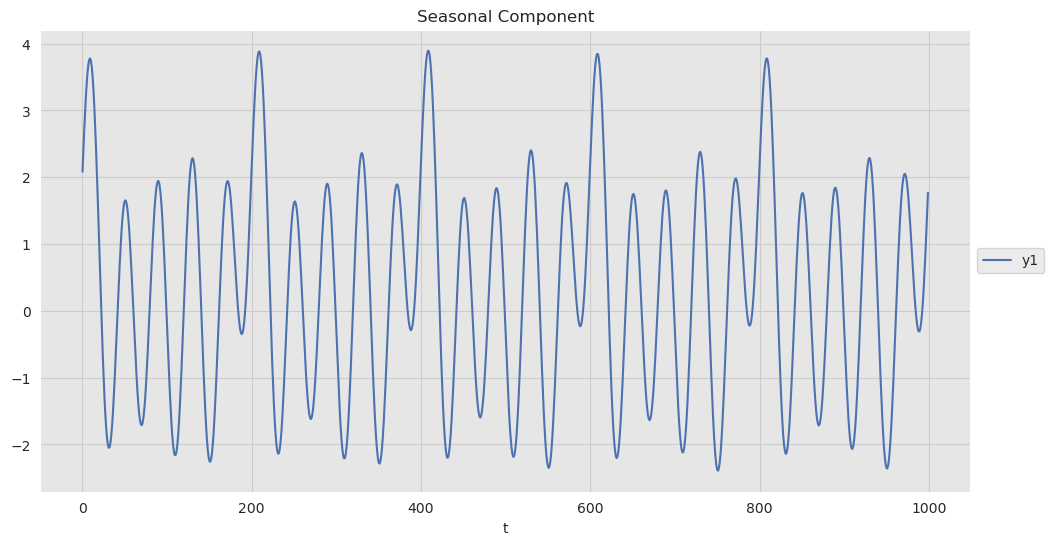

In [312]:
# Generate seasonal variables. 
def seasonal(t, amplitude, period):
    """Generate a sinusoidal curve."""
    y1 = amplitude * np.sin((2*np.pi)*t/period) 
    return y1

# Add two seasonal components. 
data_df['s1'] = data_df['t'].apply(lambda t : seasonal(t, amplitude=2, period=40))

# Define target variable. 
# data_df['y1'] =  data_df['s1']
data_df['y1'] = data_df['y1'] + data_df['s1']

# Let us plot this seasonal variable:

fig, ax = plt.subplots()
sns.lineplot(x='t', y='y1', data=data_df, color=sns_c[0], label='y1', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Seasonal Component', xlabel='t', ylabel='');

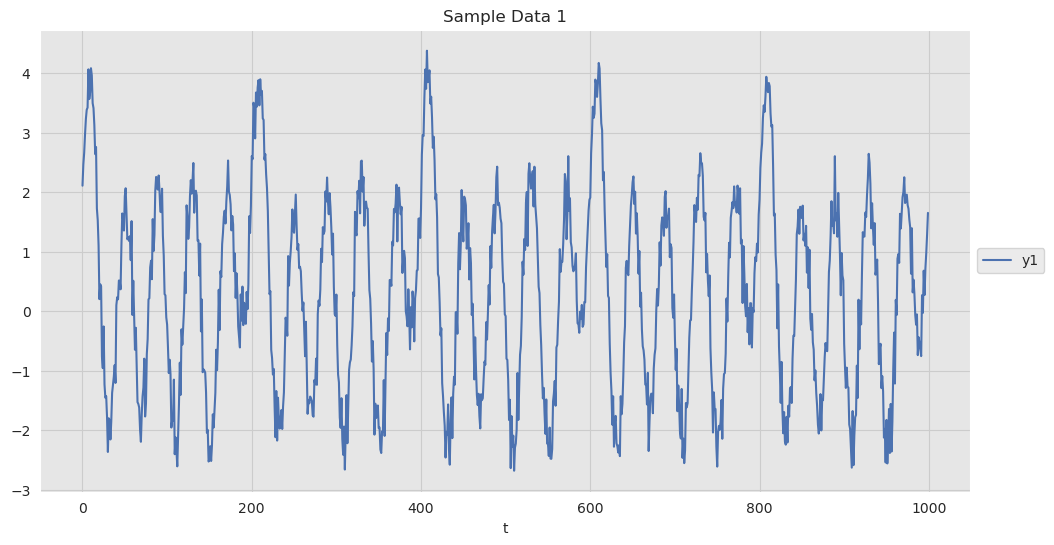

In [313]:
# Set noise standard deviation. 
sigma_n = 0.3

data_df['epsilon'] = np.random.normal(loc=0, scale=sigma_n, size=n)
# Add noise to target variable. 
data_df ['y1'] = data_df ['y1'] + data_df ['epsilon']

# Let us plot the resulting data:

fig, ax = plt.subplots()
sns.lineplot(x='t', y='y1', data=data_df, color=sns_c[0], label='y1', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Sample Data 1', xlabel='t', ylabel='');

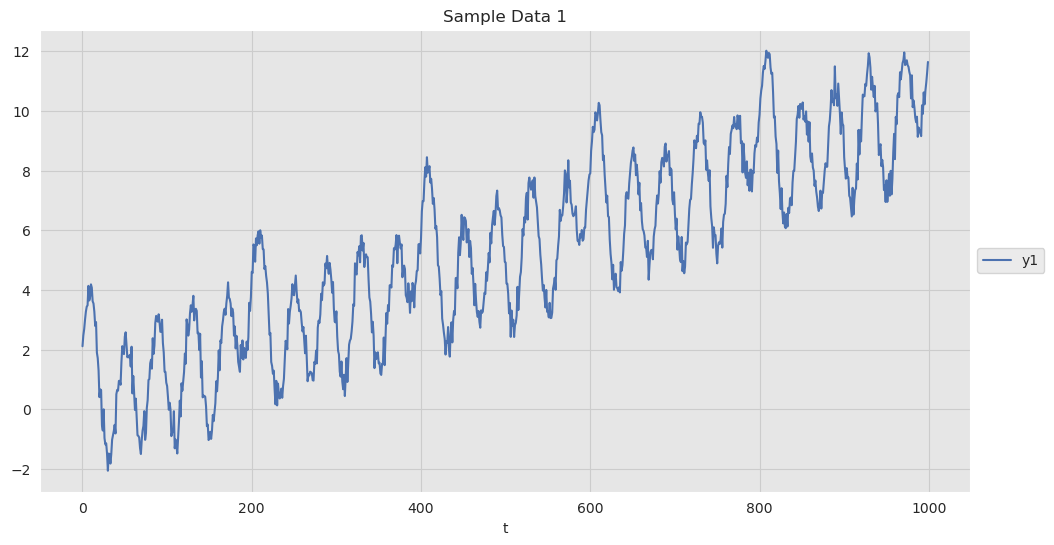

In [314]:
# Generate trend component. 
def linear_trend(beta, x):
    """Scale vector by a scalar."""
    trend_comp = beta * x 
    return trend_comp

data_df['tr1'] = data_df['t'].apply(lambda x : linear_trend(0.01, x))

# Add trend to target variable y_1. 
data_df['y1'] = data_df['y1'] + data_df['tr1']

# Let us see the trend plot:

fig, ax = plt.subplots()
sns.lineplot(x='t', y='y1', data=data_df, color=sns_c[0], label='y1', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Sample Data 1', xlabel='t', ylabel='');

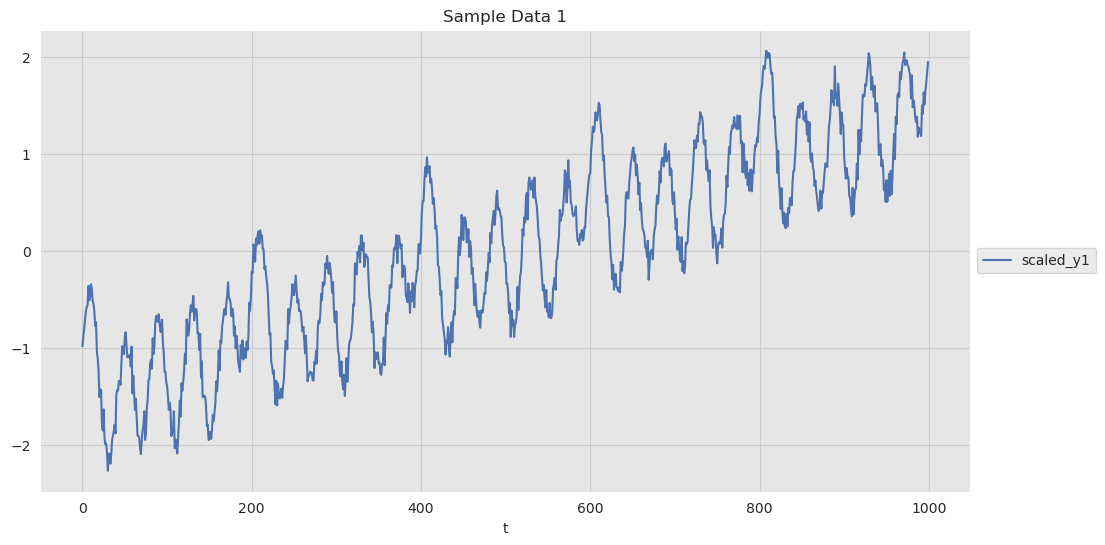

In [315]:
# Normalize the data to have zero mean and unit variance.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_df['scaled_y1'] = scaler.fit_transform(data_df['y1'].values.reshape(-1, 1)).reshape(-1, )

fig, ax = plt.subplots()
sns.lineplot(x='t', y='scaled_y1', data=data_df, color=sns_c[0], label='scaled_y1', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Sample Data 1', xlabel='t', ylabel='');

In [316]:
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RBF, ConstantKernel
from sklearn.gaussian_process.kernels import PairwiseKernel

Noise = ConstantKernel()*WhiteKernel(noise_level=0.6**2, noise_level_bounds=(0.3**2, 1**2))
# Noise = ConstantKernel()*WhiteKernel(noise_level=0.6**2, noise_level_bounds=(1e-5, 1e2))

Linear_k = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-5, 3))*PairwiseKernel(metric='linear')+ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-5, 3))

Periodic_k = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-5, 3))*ExpSineSquared(length_scale=0.2, periodicity=1.0, length_scale_bounds=(1e-5, 6.3), periodicity_bounds=(1e-5, 1e3))

RBF_k = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-5, 3))*RBF(length_scale=1.1, length_scale_bounds=(1e-5, 15.4))

SM1_k = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-5, 3))*RBF(length_scale=0.7, length_scale_bounds=(1e-5, 2.5))*ExpSineSquared(length_scale=1.0, periodicity=0.5, length_scale_bounds=(1, 1), periodicity_bounds=(1e-5, 1e3))

SM2_k = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-5, 1e2))*RBF(length_scale=1.1, length_scale_bounds=(1e-5, 15.4))*ExpSineSquared(length_scale=1.0, periodicity=1.6, length_scale_bounds=(1,1), periodicity_bounds=((1e-5, 1e3)))

K  = Noise+Linear_k+Periodic_k+RBF_k+SM1_k+SM2_k

In [317]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp1 = GaussianProcessRegressor(
    kernel=K, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)

In [318]:
X = data_df['t'].values.reshape(n, 1)
y = data_df['scaled_y1'].values.reshape(n, 1)

prop_train = 0.7
n_train = round(prop_train * n)

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

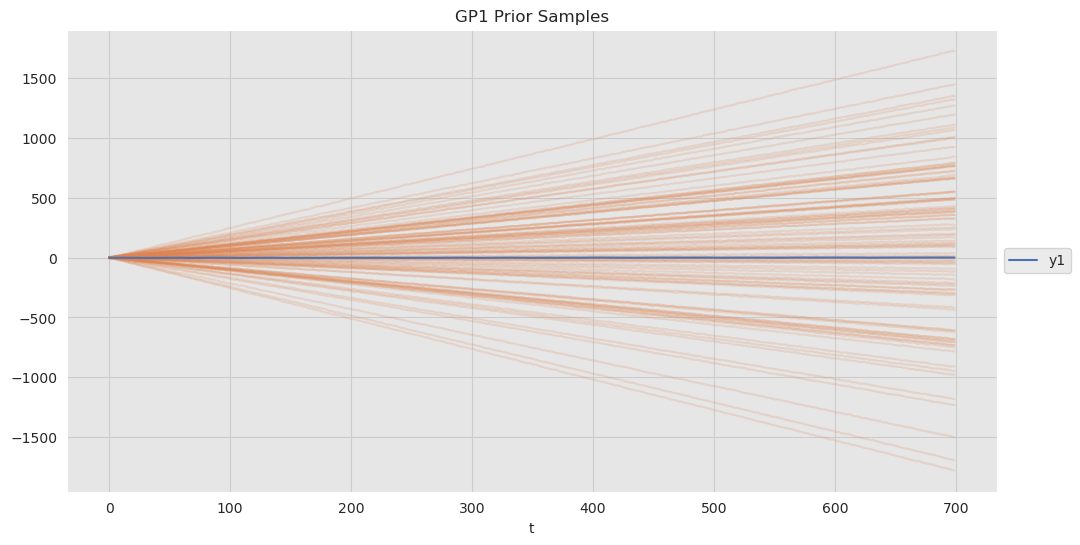

In [319]:
gp1_prior_samples = gp1.sample_y(X=X_train, n_samples=100)

fig, ax = plt.subplots()
for i in range(100):
    sns.lineplot(x=X_train[...,0], y = gp1_prior_samples[:, i], color=sns_c[1], alpha=0.2, ax=ax)
sns.lineplot(x=X_train[...,0], y=y_train[..., 0], color=sns_c[0], label='y1', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='GP1 Prior Samples', xlabel='t');

In [320]:
gp1.fit(X_train, y_train)

/home/tyler/miniconda3/envs/pymc_env/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/tyler/miniconda3/envs/pymc_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/tyler/miniconda3/envs/pymc_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and 

GaussianProcessRegressor(alpha=0.0,
                         kernel=1**2 * WhiteKernel(noise_level=0.36) + 1**2 * PairwiseKernel(gamma=1.0, metric=linear) + 1**2 + 1**2 * ExpSineSquared(length_scale=0.2, periodicity=1) + 1**2 * RBF(length_scale=1.1) + 1**2 * RBF(length_scale=0.7) * ExpSineSquared(length_scale=1, periodicity=0.5) + 1**2 * RBF(length_scale=1.1) * ExpSineSquared(length_scale=1, periodicity=1.6),
                         n_restarts_optimizer=10, normalize_y=True)

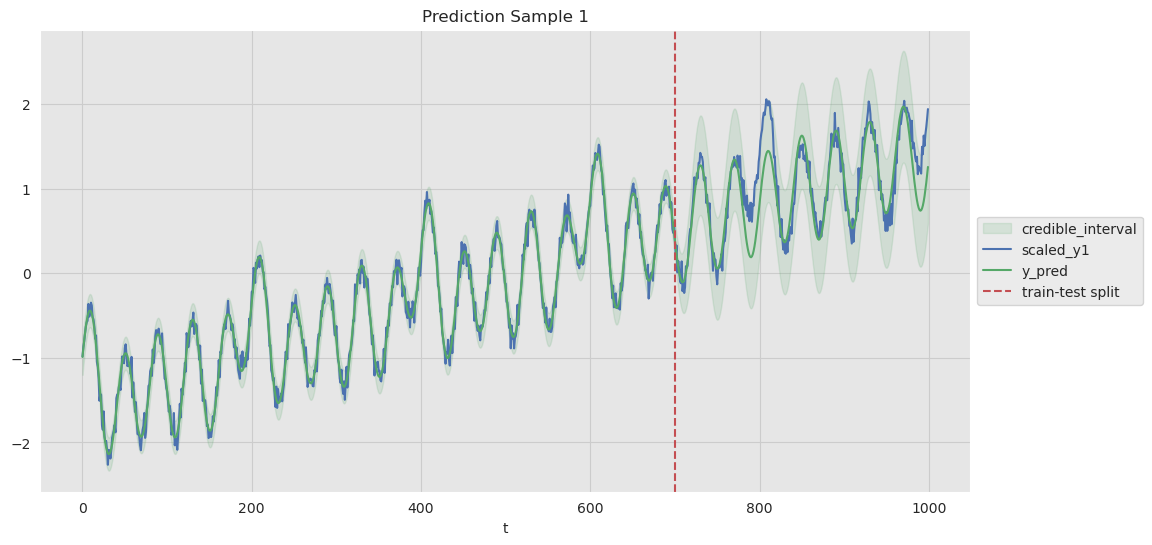

In [321]:
# Generate predictions.
y_pred, y_std = gp1.predict(X, return_std=True)

data_df['y_pred'] = y_pred
data_df['y_std'] = y_std
data_df['y_pred_lwr'] = data_df['y_pred'] - 2*data_df['y_std']
data_df['y_pred_upr'] = data_df['y_pred'] + 2*data_df['y_std']

# We plot the predictions.

fig, ax = plt.subplots()

ax.fill_between(
    x=data_df['t'], 
    y1=data_df['y_pred_lwr'], 
    y2=data_df['y_pred_upr'], 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

sns.lineplot(x='t', y='scaled_y1', data=data_df, color=sns_c[0], label = 'scaled_y1', ax=ax)
sns.lineplot(x='t', y='y_pred', data=data_df, color=sns_c[2], label='y_pred', ax=ax)

ax.axvline(n_train, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample 1', xlabel='t', ylabel='');

In [322]:
from sklearn.metrics import mean_absolute_error
print(f'R2 Score Train = {gp1.score(X=X_train, y=y_train): 0.3f}')
print(f'R2 Score Test = {gp1.score(X=X_test, y=y_test): 0.3f}')
print(f'MAE Train = {mean_absolute_error(y_true=y_train, y_pred=gp1.predict(X_train)): 0.3f}')
print(f'MAE Test = {mean_absolute_error(y_true=y_test, y_pred=gp1.predict(X_test)): 0.3f}')

R2 Score Train =  0.987
R2 Score Test =  0.769
MAE Train =  0.072
MAE Test =  0.188


/tmp/ipykernel_674117/4239692173.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=errors, ax=ax[1])


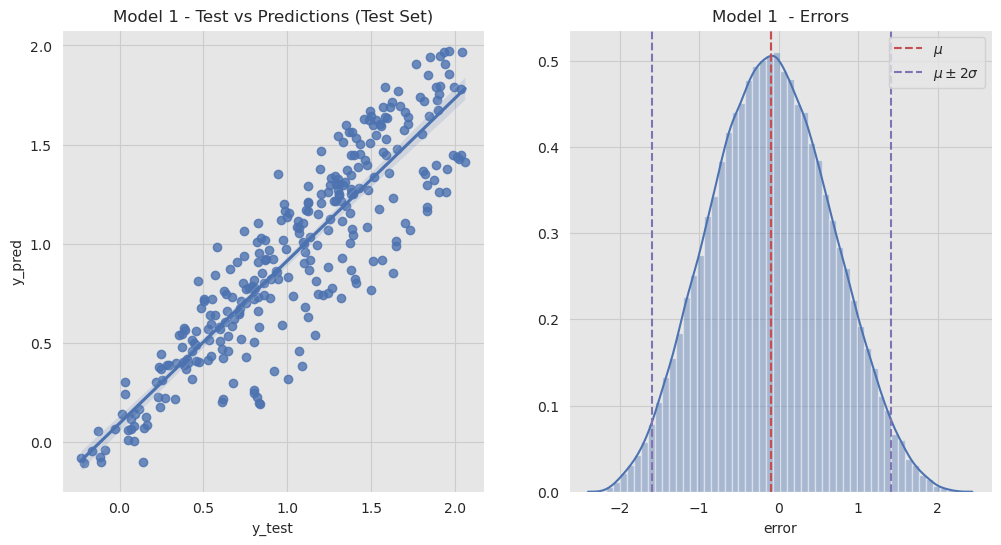

In [323]:
errors = gp1.predict(X_test) - y_test
errors = errors.flatten()
errors_mean = errors.mean()
errors_std = errors.std()

fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
sns.regplot(x=y_test.flatten(), y=gp1.predict(X_test).flatten(), ax=ax[0])
sns.distplot(a=errors, ax=ax[1])
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=errors_mean + 2*errors_std, color=sns_c[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=errors_mean - 2*errors_std, color=sns_c[4], linestyle='--')
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--')
ax[1].legend()
ax[0].set(title='Model 1 - Test vs Predictions (Test Set)', xlabel='y_test', ylabel='y_pred');
ax[1].set(title='Model 1  - Errors', xlabel='error', ylabel=None);